**Author**: JW Debelius<br>
**Creation Date**: April 2022<br>
**Version**: 1.0<br>
**Python version**: 3.8<br>

# Purpose

The goal of this notebook is to describe the demography of the participants in our newsies survey. To get a better sense of the participants, we'll look at six different aspects of the data:

* Survey infromation (when they took it and how they found out)
* Location
* Age
* Gender
* Education (in adults > 25)

# Getting ready to analyze the data

We'll start by setting up our analysis libraries and formatting the data ot make prettier plots.

In [74]:
import itertools as it
import os
import re

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd 
import seaborn as sn
import scipy

from scripts.tabulate_dict import describe_column

# Makes the data use Arial or Helvetica as its default font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial, Helvetica, Lucida Grande, sans-serif'

%matplotlib inline

We'll use a color palette called "Newsies" developed by [color-pals on tumblr](). You could theoretically skip this step if you're happy with the matplotlib defaults or if you wanted to set another color palette.

Newsies is kind of a blue/brown palette, and shoudl be semi colorblind friendly.

In [2]:
# Sets up a color palette based on the newsies
colors = ['#473934', '#C25244', '#EFDFAF', '#ABCDE3', '#6081A7', '#120E0A']
sn.set_palette(colors)
sn.color_palette(colors)

[(0.2784313725490196, 0.2235294117647059, 0.20392156862745098),
 (0.7607843137254902, 0.3215686274509804, 0.26666666666666666),
 (0.9372549019607843, 0.8745098039215686, 0.6862745098039216),
 (0.6705882352941176, 0.803921568627451, 0.8901960784313725),
 (0.3764705882352941, 0.5058823529411764, 0.6549019607843137),
 (0.07058823529411765, 0.054901960784313725, 0.0392156862745098)]

And now, we need to read in the data, data dictionary, and location information.

In [3]:
data = pd.read_csv('../data/survey_data.tsv', sep='\t', dtype=str)
data_dict = pd.read_csv('../data/data_dictionary.tsv', sep='\t', dtype=str,
                        index_col='short_name')
data.shape

(160, 210)

In [4]:
with open('../data/countries.txt', 'r') as f_:
    countries = f_.read().split('\n')
with open('../data/states.txt', 'r') as f_:
    states = f_.read().split('\n')

Let's verify that everyone consented before we move forward.

In [5]:
print(describe_column('consent', data_dict, data))

Item 1: consent (multiple choice)

I certify that the nature and purpose, the potential benefits and possible
risks associated with participation in this research study have been explained
to the above individual and that any questions about this information have
been answered. This electronic consent stands in place of my signature.


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       I am over the age of 18 and I consent to participate      160 
     ----------------------------------------------------------------------

Data cleaning notes
-------------------
   * This question was required for all participants


In [6]:
print('There are {:d} people in the final survey dataset.'.format(len(data)))

There are 160 people in the final survey dataset.


# Recruitment

Next, let's look at when people were recurited and how they found out about the survey. We'll use the `Timestamp` column (which doesn't have a data dictionary entry) which describes when the survey was submitted to google forms, and then the infromation from the `hear_about_survey` question. 

We'll start with the timestamp, and first, we'll convert it to a time, then determine a cumulative number of respondents at that time.

In [7]:
time = pd.DataFrame(pd.to_datetime(data['Timestamp']))
time.sort_values('Timestamp', ascending=True, inplace=True)
time['counter'] = 1
time['counter'] = time['counter'].cumsum()

In [8]:
time.head()

,Timestamp,counter
0,2021-05-21,1
23,2021-05-21,2
24,2021-05-21,3
25,2021-05-21,4
26,2021-05-21,5


We'll also look at the number of people recruited in a pretty graph. We can start by checking the question

In [9]:
print(describe_column('hear_about_survey', data_dict, data, show_table=False))

Item 42: hear_about_survey (checklist)

8. How did you hear about this survey? (Check all that apply)

Data cleaning notes
-------------------
   * We removed any responses that did address the original question (for
     example, "I hope you release your data")
   * We normalized responses whcih provided more descriptive information and
     standardized them back to the original source


Then, we'll pull out the data, and tabulate it as counts.

In [10]:
# Gets the data and turns it into a number
survey_cols = [c for c in data_dict.index if 'hear_about_survey' in c]
hear_about_survey = data[survey_cols].copy().astype(float)
# Checks the number of people who do no thave responese
print('There are {:d} people who did not respond'.format(
    hear_about_survey.isna().all(axis=1).sum()))
recruitment_counts = hear_about_survey.sum(axis=0)

recruit_order = ['hear_about_survey_[tumblr]', 'hear_about_survey_[twitter]', 
                 'hear_about_survey_[friend]', 'hear_about_survey_[facebook]']
recruitment_counts = recruitment_counts[recruit_order]

# I want a silly little function to clean up the column names and
# make them prettier for plotting
def extract_name(x):
    match = re.search('(?<=\[)(.*?)(?=\])', x)
    name = match.group().replace("_", ' ')
    return name

fix_names = {'friend': 'a friend'}

recruitment_counts.rename(
    index={c: fix_names.get(extract_name(c), extract_name(c))
           for c in recruitment_counts.index},
    inplace=True
)

There are 2 people who did not respond


And now, we're ready to start plotting the data!

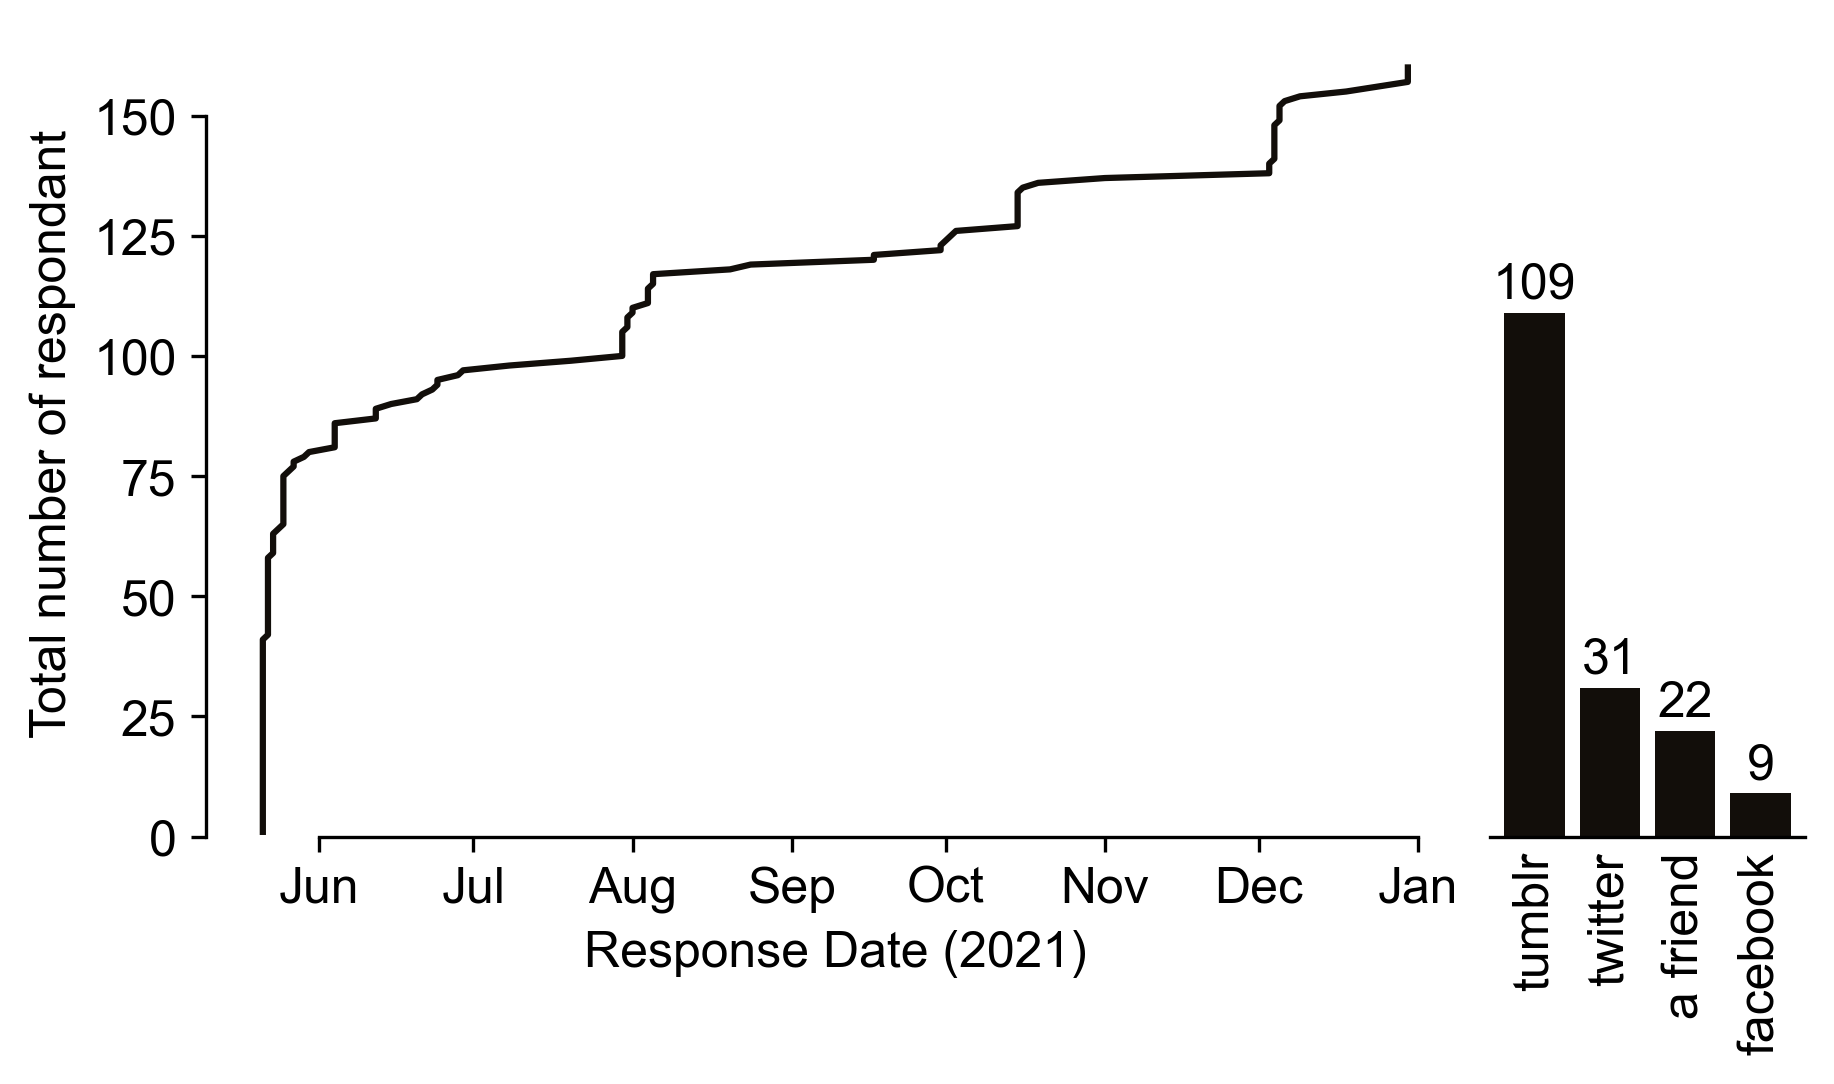

In [11]:
# We'll make a high resolution plot, because its 2022 and we're worth it
fig = plt.figure(dpi=300, constrained_layout=True, figsize=(6,3.5),
                 facecolor='None')
gs = fig.add_gridspec(1, 5)

# We'll plot the time first
ax_time = fig.add_subplot(gs[0, :-1], facecolor='None')
ax_time.plot(time['Timestamp'], time['counter'], color=colors[-1])
# Axes labels and formatting because we have data with reasonable axes and 
# we're reasonable people
ax_time.set_ylabel('Total number of respondant', size=12)
ax_time.set_xlabel('Response Date (2021)', size=12)
xfmt = md.DateFormatter('%b')
ax_time.xaxis.set_major_formatter(xfmt)
ax_time.xaxis.set_tick_params(labelsize=12)
ax_time.yaxis.set_tick_params(labelsize=12)
sn.despine(ax=ax_time, top=True, right=True, trim=True)

# And then we'll add a second panel describing the platforms where people 
# heard about the survey.
ax_hear = fig.add_subplot(gs[0, -1], facecolor='None', sharey=ax_time)
ax_hear.bar(
    x=np.arange(0, 4),
    height=recruitment_counts,
    color=colors[-1],
)   
# We'll add a count label, because its pretty
for i, top_ in enumerate(recruitment_counts.values):
    ax_hear.text(i, top_ + 1, f'{top_:1.0f}', 
                 ha='center', va='bottom', size=12)
# and then each bar gets it won label and description, which we'll clean up
# to make nicer
ax_hear.set_xticks(np.arange(0, 4))
ax_hear.set_xticklabels(recruitment_counts.index)
ax_hear.xaxis.set_tick_params(rotation=90, bottom=False, length=0, labelsize=12)
ax_hear.yaxis.set_tick_params(left=False, labelleft=False)
sn.despine(ax=ax_hear, top=True, right=True, trim=False, left=True)

# Age

The next demographic question I want to look at is age. This is in a column called `demography_age`. 

In [12]:
print(describe_column('demography_age', data_dict, data))

Item 35: demography_age (multiple choice)

1. How old are you?


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       18 - 21                                                    70 
       22 - 25                                                    28 
       26 - 30                                                    20 
       31 - 35                                                    12 
       36 - 40                                                    18 
       41 - 45                                                     9 
       46 - 60                                                     3 
     ----------------------------------------------------------------------



It looks like we don't have that many people over 40, so I'm going to group everyone over 40 into a single group.

In [13]:
age = data['demography_age'].copy()
age.replace({'41 - 45': '41+',
             "46 - 60": '41+',
             },
            inplace=True)
age_counts = age.value_counts().sort_index()
age_counts

18 - 21    70
22 - 25    28
26 - 30    20
31 - 35    12
36 - 40    18
41+        12
Name: demography_age, dtype: int64

And then we're going to make a pretty little graph showing the number of participants because that's better to display in powerpoint

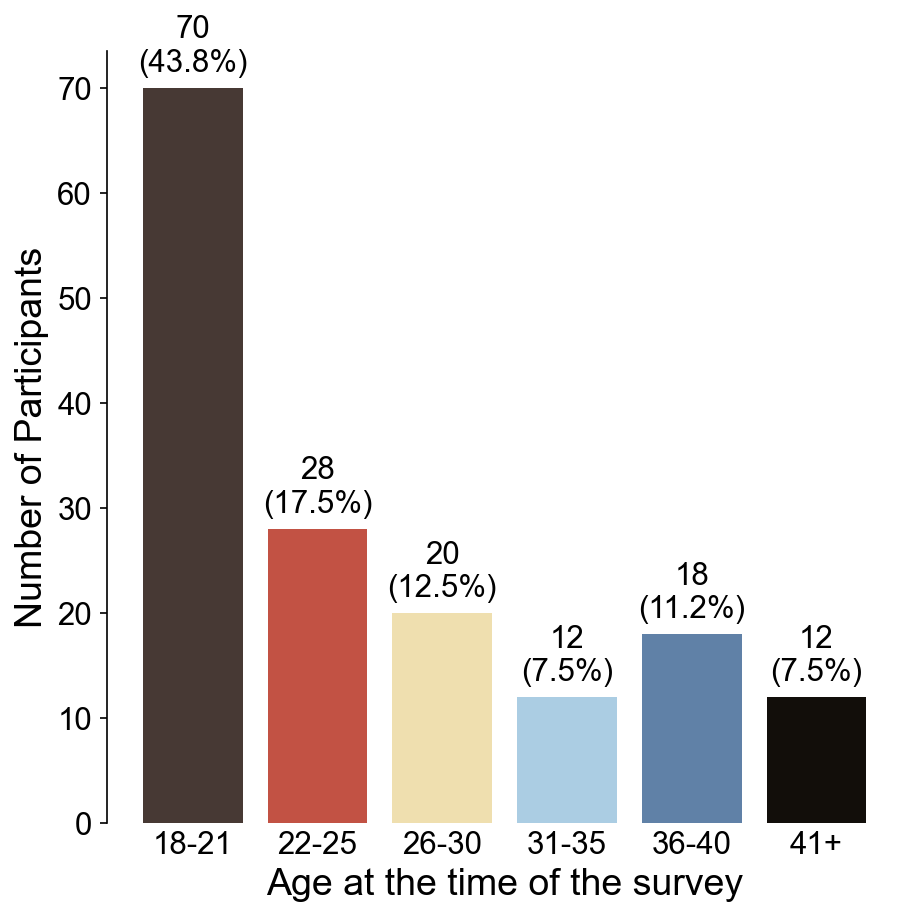

In [14]:
fig = plt.figure(constrained_layout=True,
                 # dpi=300,
                 dpi=150,
                 figsize=(6,6),
                 facecolor='None',
                 )
ax = fig.add_subplot(1,1,1, facecolor='None')
ax.bar(
    x=np.arange(len(age_counts)),
    height=age_counts.values,
    color=colors
)
for x, v in enumerate(age_counts.values):
    ax.text(x, v + 1, f'{v:>2d}\n({v/160:>4.1%})', 
            ha='center', 
            va='bottom',
            size=15,
            )
ax.set_xticks(np.arange(len(age_counts)))
ax.set_xticklabels([a.replace(" ", '') for a in age_counts.index.values])
ax.xaxis.set_tick_params(bottom=False, length=0, labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xlabel('Age at the time of the survey', size=18)
ax.set_ylabel('Number of Participants', size=18)

sn.despine(left=False, right=True, top=True, bottom=True)

# Gender

I also want to look at gender, and whether respondants were trans. That's broken up into two questions: gender and trans identity.

In [15]:
print(describe_column('demography_gender', data_dict, data, show_table=False))

Item 36: demography_gender (multiple choice)

2. What is your gender identity?

Data cleaning notes
-------------------
   * Based on participant free text responses, we added a category indicating
     the participant was questioning their gender. For example "IDK" was mapped
     to this category
   * Based on an IRB requirement to group demographic data, we remapped an
     individual who described themself as a "demi-girl" and "genderfluid" to
     genderqueer


In [16]:
print(describe_column('demography_trans', data_dict, data, show_table=False))

Item 37: demography_trans (multiple choice)

3. Do you identify as trans?



We'll pull out the data, clean it up, and determine the number of people who answered the question.

In [17]:
gender = data[['demography_gender', 'demography_trans']].copy()
gender.rename(columns={c: c.split("_")[1] for c in gender.columns}, 
              inplace=True)
gender.dropna(how='all', inplace=True)
gender.replace({'No': 0, 'Yes': 1}, inplace=True)

print('There are {0:d} respondants who provided gender information'.format(
    len(gender)
))

There are 158 respondants who provided gender information


In [18]:
gender_order = ['Female', 'Male', 'Nonbinary', 'Genderqueer', 'Questioning']
gender_counts = gender['gender'].value_counts()[gender_order]
gender['spacer'] = 1
trans_mean  = gender.groupby('gender')['trans'].mean()
trans_count = gender.groupby(['gender', 'trans'], sort=True)['spacer'].count()
trans_count = trans_count.unstack().fillna(0).astype(int).T

In [19]:
print(gender_counts)

Female         109
Male            12
Nonbinary       27
Genderqueer      6
Questioning      4
Name: gender, dtype: int64


In [20]:
print('The percentage of trans participant in each gender identity group:')
trans_mean.loc[gender_order].apply(lambda x: f'{x:1.2%}')

The percentage of trans participant in each gender identity group:


gender
Female          0.00%
Male           66.67%
Nonbinary      64.00%
Genderqueer    66.67%
Questioning     0.00%
Name: trans, dtype: object

In [21]:
print('{0:1.1%} of participants are trans'.format(gender['trans'].mean()))

17.9% of participants are trans


And then another plot because pictures are better than words

/Users/jwdebelius/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/jwdebelius/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


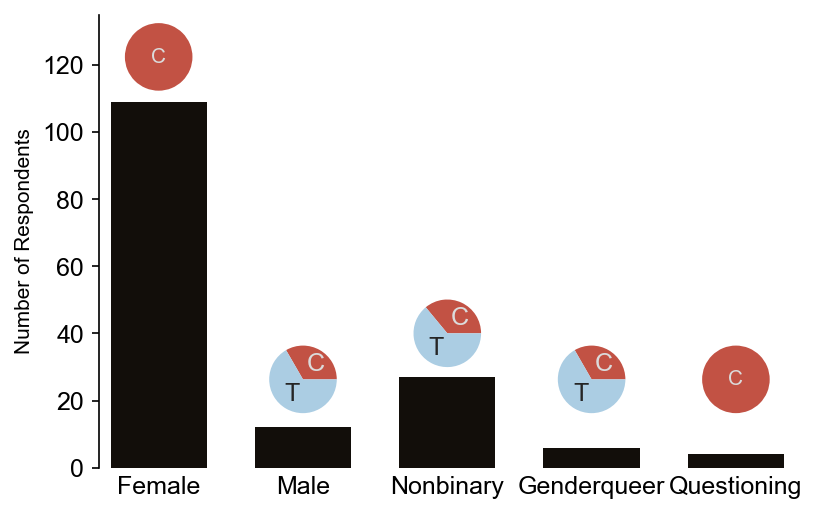

In [22]:
# Hard codes a location because that's how life goes sometimes
# these are based on having 10 axis units for each plot
gender_axes = {'Female': 0, 
               'Male': 7, 
               'Nonbinary': 6,
               'Genderqueer': 7, 
               'Questioning': 7}

fig = plt.figure(constrained_layout=True,
                 dpi=150,
                 facecolor='None',
                 )

gs = fig.add_gridspec(10, 5)
bar_ax = []
pie_ax = []

# Creates a pretty background 
bar_ref = fig.add_subplot(gs[:, :], facecolor='None')
bar_ref.set_ylim([0, 135])
bar_ref.set_xticks([])
bar_ref.yaxis.set_tick_params(labelsize=12)
bar_ref.xaxis.set_tick_params(bottom=False, labelbottom=False)
bar_ref.set_ylabel('Number of Respondents')

# For each gender column, make a pretty graph!
for i, (gen, py) in enumerate(gender_axes.items()):
    ax_b = fig.add_subplot(gs[:, i], sharey=bar_ref, facecolor='None')
    ax_p = fig.add_subplot(gs[py:(py+2), i], facecolor='None')
    
    ax_b.bar(x=0, 
             height=gender_counts[gen], 
             color=colors[-1]
             )
    # ax_b.text(0, gender_counts[gen] + 1, 
    #           '{0:3d}\n({1:>4.1%})'.format(
    #               gender_counts[gen], (gender_counts[gen] / len(gender))),
    #           ha='center', va='bottom', size=12)
    ax_b.set_xlim(-0.5, 0.5)
    ax_p.pie(trans_count[gen], colors=[colors[1], colors[-3]])
    
    # And then we hide the yticks on the bar axis becuase it just makes hte 
    # plot cleaner
    ax_b.xaxis.set_tick_params(left=False, labelleft=False, length=0,
                               right=False, labelright=False)
    ax_b.yaxis.set_tick_params(left=False, labelleft=False, length=0,
                               right=False, labelright=False)
    ax_b.set_xlabel(gen, size=12)
    
    if gen in {'Female', 'Questioning'}:
        ax_p.text(0, 0, 'C', size=10, ha='center', va='center', 
                  color='#dbdbdb')
    else:
        ax_p.text(0.1, 0.1, 'C', size=12, ha='left', va='bottom', 
                  color='#dbdbdb')
        ax_p.text(-0.1, -0.1, 'T', size=12, ha='right', va='top', 
                  color='#252525')
    sn.despine(ax=ax_b, left=True, right=True, top=True, bottom=True)
    
sn.despine(ax=bar_ref, top=True, bottom=True, right=True)

# Orientation

It would also probably make sense to look at sexual orientation, if for no other reason than because someone will probably want to know.

In [23]:
print(describe_column('demography_orientation_', data_dict, data, show_table=False))

Item 38: demography_orientation (checklist)

4. What is your sexual orientation? (Please select all that apply)

Data cleaning notes
-------------------
   * We combined the existing category, "Asexual or Aromantic spectrum" with
     participant provided responses indciating demisexuality into a single
     category including asexual, aromatic, and demisexual individuals
   * We removed non-responses that didn't directly answer the question of sexual
     orientation
   * We combined the existing pansexual category with particiapnt provided
     omnisexual orientation (`pansexual_omnisexual`)
   * Based on participant responses, we added a category to indicate the
     participant was questioning their sexual orientation


So, let's pull out the data!

In [24]:
orientation_cols = [c for c in data_dict.index 
                    if 'demography_orientation_' in c]
orientation = data[orientation_cols].astype(float).copy()
orientation.rename(columns={c: extract_name(c) for c in orientation.columns},
                   inplace=True
                   )
orientation.dropna(inplace=True, how='all')
orientation = (orientation == 1)

print(' '.join([
    'There are {0:d} respondants who provided'.format(len(orientation)),
    'information about their sexual orientation'
]))

There are 155 respondants who provided information about their sexual orientation


I want to start by getting the number of people total who selected a given identity, keepong in mind that someone could select multiple.

In [25]:
pd.DataFrame({'number of responses': orientation.sum(axis=0),
              'percent of respondents': orientation.mean(axis=0).apply(lambda x: f'{x:1.1%}')
              })

,number of responses,percent of respondents
ace aro demi,41,26.5%
bisexual,53,34.2%
heterosexual,44,28.4%
homosexual,14,9.0%
pansexual omnisexual,4,2.6%
queer,32,20.6%
questioning,7,4.5%


I want to start by checking how many people have selected multiple orientations/identities.

In [26]:
orientation.sum(axis=1).value_counts().sort_index()

1    122
2     28
3      3
4      2
dtype: int64

So most people selected a single orientation. I want to know which they selected. I want a pretty table that summarizes the number of people who identify with a specific orientation as their only orientation and who have it as part of a multiple orientation identity. (I know my language here probably isn't entirely correct, but Im not sure how to phrase this... my job usually involves more computer code and less discussion of identity.)

In [27]:
only_ids = orientation.loc[orientation.sum(axis=1) == 1].copy()
multi_ids = orientation.loc[orientation.sum(axis=1) > 1].copy()

In [28]:
df_look_up = {'only': orientation.loc[orientation.sum(axis=1) == 1].copy(),
              'multi': orientation.loc[orientation.sum(axis=1) > 1].copy(),
              'total': orientation,
             }
orient_counts = pd.concat(axis=1, objs=[
    pd.DataFrame({
    (id_, 'count'): df.sum(axis=0),
    (id_, 'mean_sub'): df.mean(axis=0),
    (id_, 'mean_total'): df.sum(axis=0) / len(orientation)
    })
    for id_, df in df_look_up.items()
])
orient_counts.sort_values(('total', 'count'), ascending=False, inplace=True)

In [29]:
def tidy_orientation_table(x):
    return '{count:>2.0f} ({mean_total:>6.2%})'.format(**x.to_dict())

tidied_orient_counts = pd.DataFrame({
    col_: orient_counts[col_].apply(tidy_orientation_table, axis=1)
    for col_ in ['total', 'only', 'multi']
})
tidied_orient_counts.rename(
    columns={'total': 'All Participants',
             'only': 'Only Identitity',
             'multi': 'One of multiple identities'},
    index={'bisexual': 'Bisexual',
           'heterosexual': 'Heterosexual (straight)',
           'ace aro demi': 'Asexual/aromatic spectrum or demisexual',
           'queer': 'Queer',
           'homosexual': 'Homosexual (gay)',
           'questioning': 'Questioning',
           'pansexual omnisexual': 'Pansexual or Omnisexual',
          },
    inplace=True
)
tidied_orient_counts

,All Participants,Only Identitity,One of multiple identities
Bisexual,53 (34.19%),34 (21.94%),19 (12.26%)
Heterosexual (straight),44 (28.39%),42 (27.10%),2 ( 1.29%)
Asexual/aromatic spectrum or demisexual,41 (26.45%),16 (10.32%),25 (16.13%)
Queer,32 (20.65%),16 (10.32%),16 (10.32%)
Homosexual (gay),14 ( 9.03%),7 ( 4.52%),7 ( 4.52%)
Questioning,7 ( 4.52%),5 ( 3.23%),2 ( 1.29%)
Pansexual or Omnisexual,4 ( 2.58%),2 ( 1.29%),2 ( 1.29%)


# Respondent Location

I want to look at both the country and state where respondants live. We're going to use the country and state files for this, which give the list of locations verses let us link these to additional participant information.

## Nationality

We'll start by pulling out the location information using the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) python package, which you should probaby mess with in your own right if you're interested. We'll pull in the country information, and set up the plot to color countries just shy of white when they haven't been selected, and color them using the pallete when they're present.

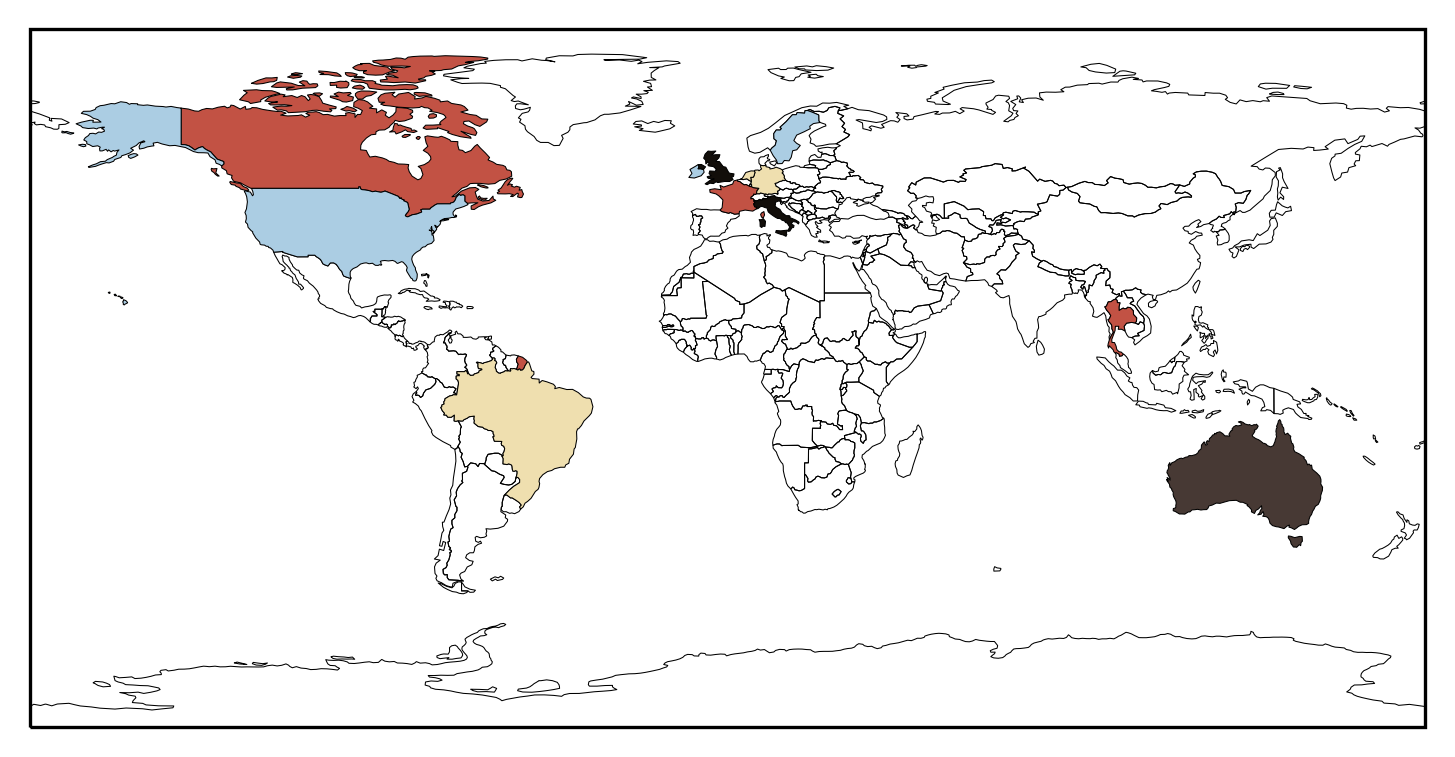

In [30]:
country_shp = \
    natural_earth(resolution='110m',
                            category='cultural', 
                            name='admin_0_countries'
                            )
show_countries = [
    r.geometry for r in Reader(country_shp).records()
    if (r.attributes['NAME'] in countries)
]

def color_countries(geom):
    if geom in show_countries:
        i = int(np.random.randint(0, len(colors), 1))
        facecolor = sn.color_palette()[i]
    else:
        facecolor = 'None'
    return {'facecolor': facecolor, 'edgecolor': 'black', 'linewidth': 0.25}


fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(), facecolor='None')
ax.add_geometries(geoms=Reader(country_shp).geometries(),
                  crs=ccrs.PlateCarree(),
                  styler=color_countries,
                  )

## States

I also want a map to highlight the US states where participants live.  Because fo the 4 color theorem, I ended up hard coding the state colors.

/Users/jwdebelius/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/jwdebelius/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jwdebelius/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jwdebelius/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/cartopy/cr

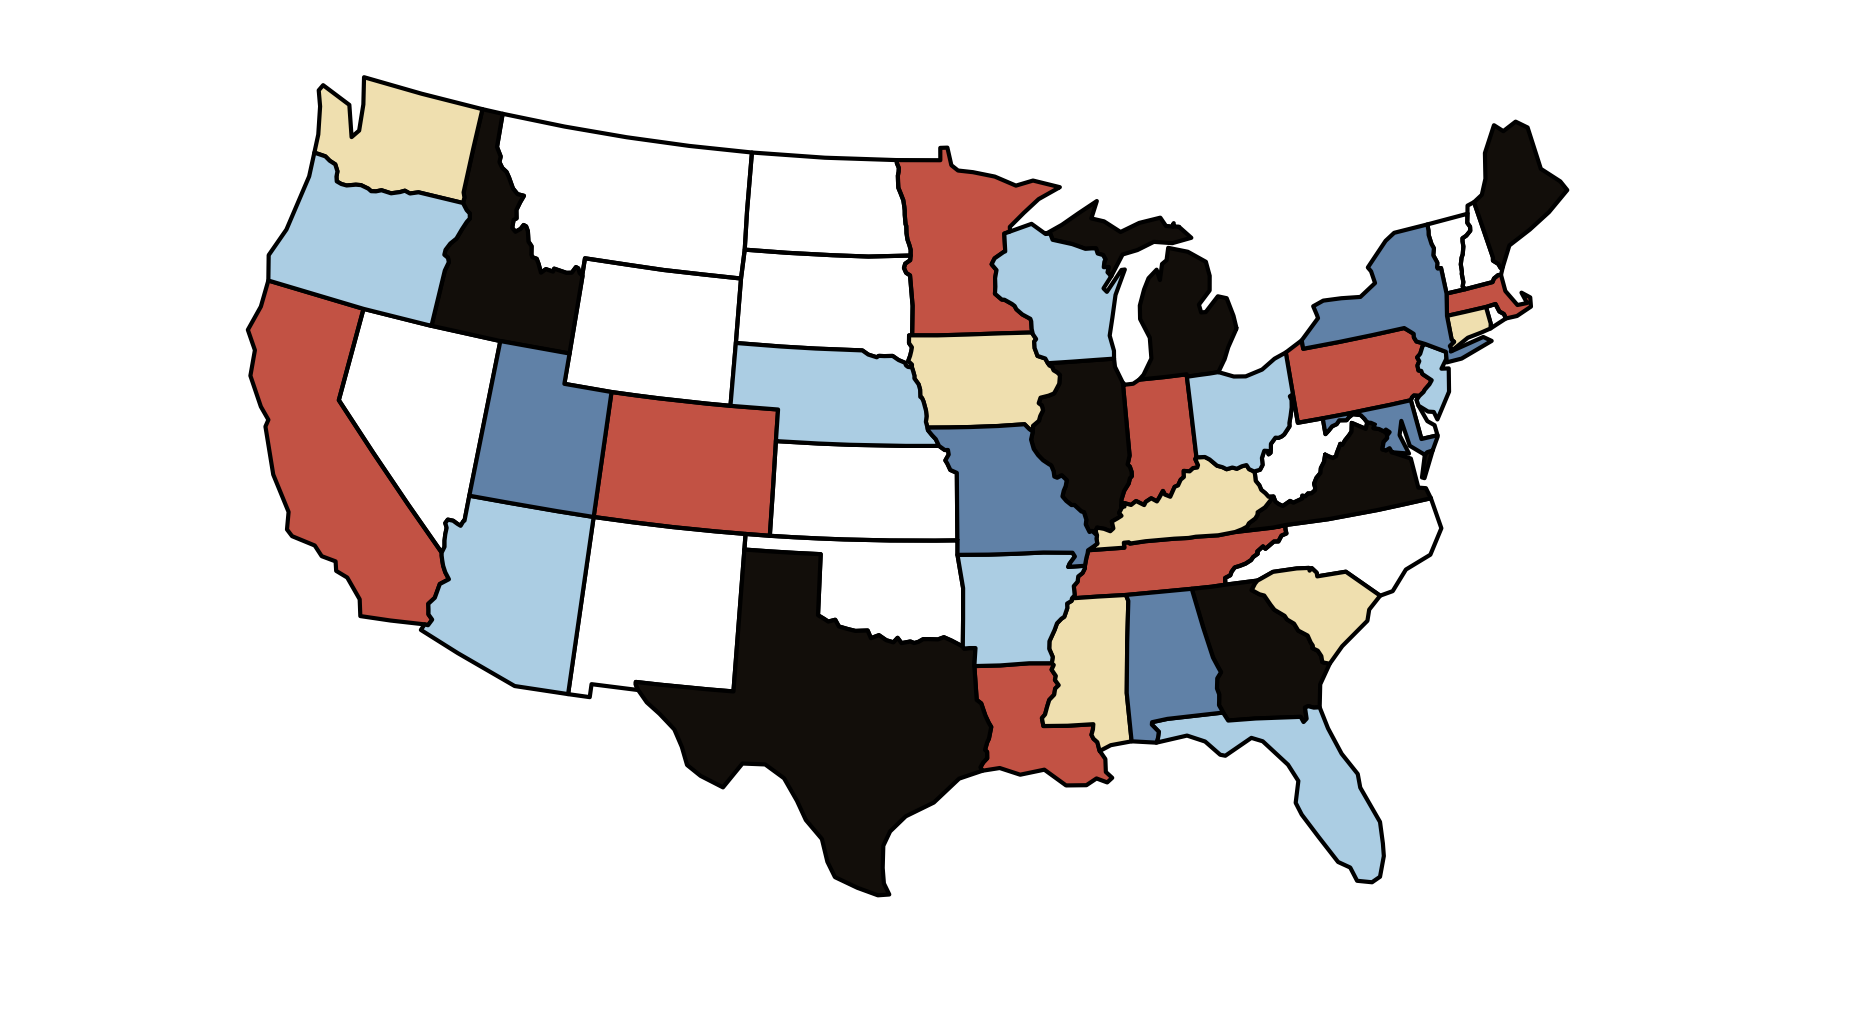

In [31]:
# Gets the administrative information
shapename = 'admin_1_states_provinces_lakes'
states_shp = natural_earth(resolution='110m', category='cultural', 
                           name=shapename)

# Pulls out the states that need to be shown and hidden
show_states = [
    r for r in Reader(states_shp).records()
    if (r.attributes['name'] in states)
]
color_groups = {
    1: ['Indiana', 'Pennsylvania', 'Massachusetts', 'Minnesota', 'Colorado',
        'Louisiana', 'California', 'Tennessee'],
    2: ['Kentucky', 'Iowa', 'Mississippi', 'South Carolina', 'Washington',
        'Connecticut'],
    3: ['Nebraska', 'Florida',  'Ohio', 'New Jersey', 'Arizona', 'Arkansas',
        'Wisconsin', 'Oregon'],
    4: ['Utah', 'Missouri', 'Alabama', 'New York', 'Maryland'],
    5: ['Illinois', 'Georgia', 'Michigan', 'Maine', 'Conneticut', 'Idaho',
        'Texas',  'Virginia']
}
sub_colors = np.array(colors)[np.array(colors) != '#B8AEB3']
state_colors = {
    sub_colors[i]: [r.geometry for r in Reader(states_shp).records()
                    if (r.attributes['name'] in color_states)]
    for i, color_states in color_groups.items()
}

fig = plt.figure(dpi=300, facecolor='None', constrained_layout=True)
# # to get the effect of having just the states without a map "background"
# # turn off the background patch and axes frame. We'll also center on the US.
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(),
                  frameon=False)
ax.patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

# Colors the states using a hard-coded function because apparently
# writing the four color theorem is beyond me.
def _find_states(geom):
    facecolor='None'
    for color, states in state_colors.items():
        if geom in states:
            facecolor = color
    return {'facecolor': facecolor, 'edgecolor': 'k', 'linewidth': 1}

ax.add_geometries(geoms=Reader(states_shp).geometries(),
                  crs=ccrs.PlateCarree(),
                  styler=_find_states,
                  )

# Education

Finally, I want to look at educational attainment among fans. Specifically, I want to look at fans over the age of 25. Other demography work I've done has used this threhhold. Working with younger fans may skew the results since its likely that they're either still in school, but their education might be affected by the pandemic which has lead to just generla weirdness. So, yeah, education in people over 25.

In [32]:
print(describe_column('demography_education', data_dict, data, show_table=False))

Item 41: demography_education_level (multiple choice)

6. What is your highest level of education?



In [33]:
data['demography_age'].unique()

array(['18 - 21', '22 - 25', '26 - 30', '31 - 35', '46 - 60', '41 - 45',
       '36 - 40'], dtype=object)

In [34]:
over_25s = ['26 - 30', '31 - 35', '46 - 60', '41 - 45', '36 - 40']
edu_ = data.loc[data['demography_age'].isin(over_25s), 'demography_education_level'].copy()
edu_.dropna(inplace=True)
print(' '.join([
    'There are {:d} respondents over 25 who provided'.format(len(edu_)),
    'information about their educational attainment'
]))

There are 62 respondents over 25 who provided information about their educational attainment


We can tabulate the results...

In [35]:
edu_.value_counts()

Bachelor's Degree                                  26
PhD or professional degree (MD, JD, etc)           16
Master’s degree                                    14
Associate's Degree                                  3
Some college                                        2
Currently in a professional or graduate program     1
Name: demography_education_level, dtype: int64

I think for the sake of tidiness, I'm going to group the person in graduate school as having a bachelors and the people with college or an associates together

In [36]:
edu_.replace(
    {'Currently in a professional or graduate program': "Bachelor's Degree",
     'Some college': 'Associates or some college',
     "Associate's Degree": 'Associates or some college',
     },
     inplace=True
    )

In [37]:
edu_counts = pd.DataFrame(
    data=[edu_.value_counts(), 
          (edu_.value_counts() / len(edu_)).apply(lambda x: f'{x:>4.1%}')
          ],
    index=['number of respondents', 'percent over 25']
).T
edu_order = ['Associates or some college', "Bachelor's Degree", 
             "Master’s degree", 'PhD or professional degree (MD, JD, etc)']
edu_counts = edu_counts.loc[edu_order]
edu_counts

,number of respondents,percent over 25
Associates or some college,5,8.1%
Bachelor's Degree,27,43.5%
Master’s degree,14,22.6%
"PhD or professional degree (MD, JD, etc)",16,25.8%


# Media Seen

Finally, I want to pull out the media that people have seen, because that seems like an important demographic question for this show.

In [38]:
print(describe_column('media_seen', data_dict, data, show_table=False))

Item 4: all_media_seen (checklist)

3. How many of the following have you seen? (Select all that apply)



In [55]:
media_cols = [c for c in data_dict.index if 'media_seen' in c]
names = data_dict.loc[media_cols, 'original_answer'].to_dict()

In [47]:
print('There is {0} person who did not respond to this question.'.format(data[media_cols].isna().all(axis=1).sum()))

There is 1 person who did not respond to this question.


In [56]:
media = data[media_cols].copy().dropna()
media = media.astype(float)
media.rename(columns=names, inplace=True)

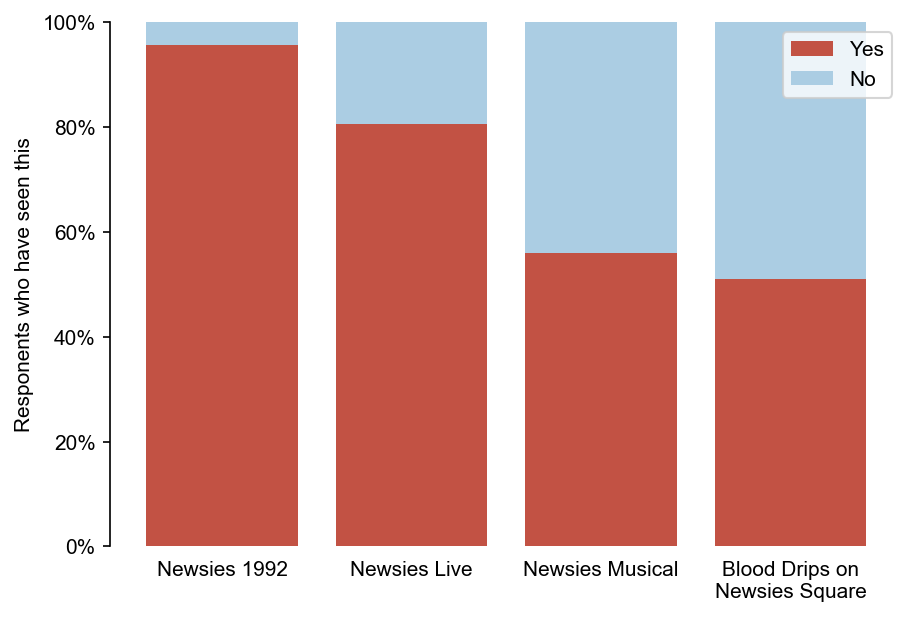

In [78]:
fig = plt.figure(dpi=150, constrained_layout=True, facecolor='None')
ax = fig.add_subplot(1,1,1, facecolor='None')
ax.bar(np.arange(0, 4),
       bottom=0, 
       height=media.mean(axis=0),
       color=colors[1],
       label='Yes',
      )
ax.bar(np.arange(0, 4),
       bottom=media.mean(axis=0),
       height=1-media.mean(axis=0),
       color=colors[3],
       label='No',
      )
ax.legend()
ax.set_xticks(np.arange(0, 4))
ax.set_xticklabels([c.split(' (')[0].replace('on ', 'on\n') 
                    for c in media.columns])


ax.set_ylim(0, 1)
ax.xaxis.set_tick_params(bottom=False)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0%}'))

ax.set_ylabel('Responents who have seen this')

sn.despine(left=False, right=True, top=True, bottom=True, trim=True)